## Digital Diary Project Analysis

#### by William Ajayi

In [ ]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import panel as pn

%matplotlib inline

### 1) Reading The Data

In [433]:
# reading the csv
df = pd.read_csv('/Users/willoricch/Desktop/ddsummary.csv', header=1, index_col=0)
df.head()
df.head().to_clipboard()

### 2) Formatting and Cleaning the Columns
- This is very useful for how I want to organize the data which is having each row represenet a new week  
- Instead of 60 with each participant we have 540 for the 9 weeks (60 participants x 9 weeks = 540 rows)

In [ ]:
# Formatting the columns so each of them have the exact same name
df.columns = df.columns.str.split('.').str[0]

- Segmenting each week into a new dataframe to prepare for concatenation
- This will help for organizing the data in the ideal format

In [ ]:
week1 = df.iloc[:, 0:12]
week1['Week'] = 'Week 1'

week2 = df.iloc[:, 24:36]
week2['Week'] = 'Week 2'

week3 = df.iloc[:, 49:61]
week3['Week'] = 'Week 3'

week4 = df.iloc[:, 73:85]
week4['Week'] = 'Week 4'

week5 = df.iloc[:, 98:110]
week5['Week'] = 'Week 5'

week6 = df.iloc[:, 123:135]
week6['Week'] = 'Week 6'

week7 = df.iloc[:, 148:160]
week7['Week'] = 'Week 7'

week8 = df.iloc[:, 173:185]
week8['Week'] = 'Week 8'

week9 = df.iloc[:, 186:]
week9['Week'] = 'Week 9'

In [340]:
all_df = pd.concat([week1, week2, week3, week4, week5, week6, week7, week8, week9])

data = all_df.copy()

data.drop(df.columns[[7, 8, 9, 10, 11]], axis=1, inplace=True)



- A peek into the newly organized data

In [ ]:
# Displaying the newly cleaned and formatted dataframe
data.head()

- Making a new column tracking which cohort each participant belongs to

In [341]:
data["Cohort_Code"] = data.index.str.split("_").str[-1]

cohort_map = {
    "SSA": "Storytelling",
    "SLA": "Lens",
    "SEA": "Engineering",
    "SDA": "Design"
}

data["Cohort"] = data["Cohort_Code"].map(cohort_map)

data.drop(columns='Cohort_Code', axis=1, inplace=True)


### 3) General Visualizations

#### Creating a heatmap to see which categorials columns correlated the most to one another

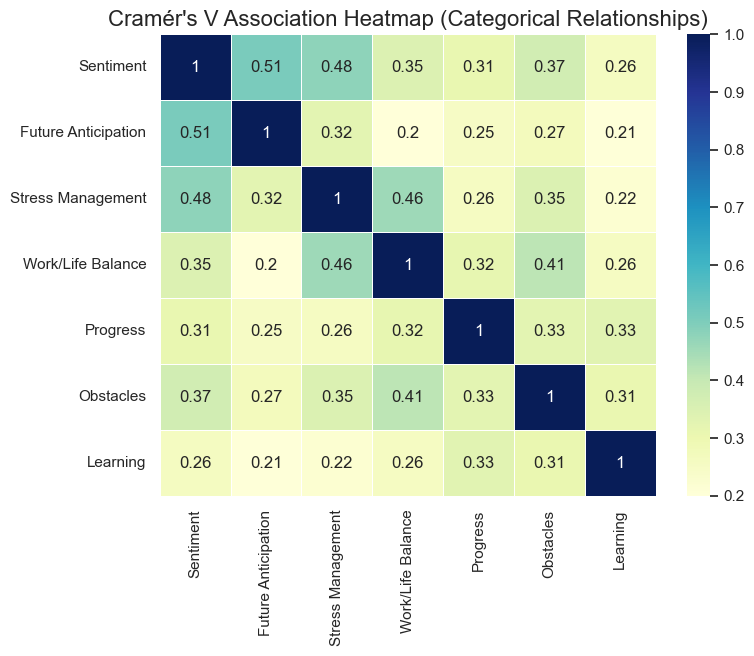

In [428]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

cat_cols = [
    'Sentiment',
    'Future Anticipation',
    'Stress Management',
    'Work/Life Balance',
    'Progress',
    'Obstacles',
    'Learning'
]

cramer_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    columns=cat_cols,
    index=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])

plt.figure(figsize=(8,6))
sns.heatmap(cramer_matrix, annot=True, cmap="YlGnBu", linewidths=.5)
plt.title("Cramér's V Association Heatmap (Categorical Relationships)", fontsize=16)
plt.show()



- From the heatmap, several key relationships emerge:
    - Sentiment and Future Anticipation show the strongest correlation among all categorical columns at 0.51
    - Stress Management and Sentiment follow closely at 0.48
    - Stress Management and Obstacles (0.46) and Stress Management and Learning (0.46) also demonstrate meaningful alignment

- Interpretation of trends:
    - These relationships are logical because a participant’s overall sentiment about a week often connects to emotional experiences recorded in categories like Stress Management, Obstacles, and Future Anticipation
    - In practice, a positive or negative week can shape both current stress levels and expectations for upcoming weeks
    - This supports the idea that weekly experiences influence both present emotional state and future outlook

Insight summary:
-  How someone feels about their week influences what challenged them, how stressed they were, and how optimistic or uncertain they feel moving forward
    

#### Creating multiple stacked bar charts

/var/folders/lm/91n7h9b14bz844p940x4ycd00000gn/T/ipykernel_79324/2559599677.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = sub.groupby("Week")[["Positive", "Negative", "Neutral"]].sum()
/var/folders/lm/91n7h9b14bz844p940x4ycd00000gn/T/ipykernel_79324/2559599677.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = sub.groupby("Week")[["Positive", "Negative", "Neutral"]].sum()
/var/folders/lm/91n7h9b14bz844p940x4ycd00000gn/T/ipykernel_79324/2559599677.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

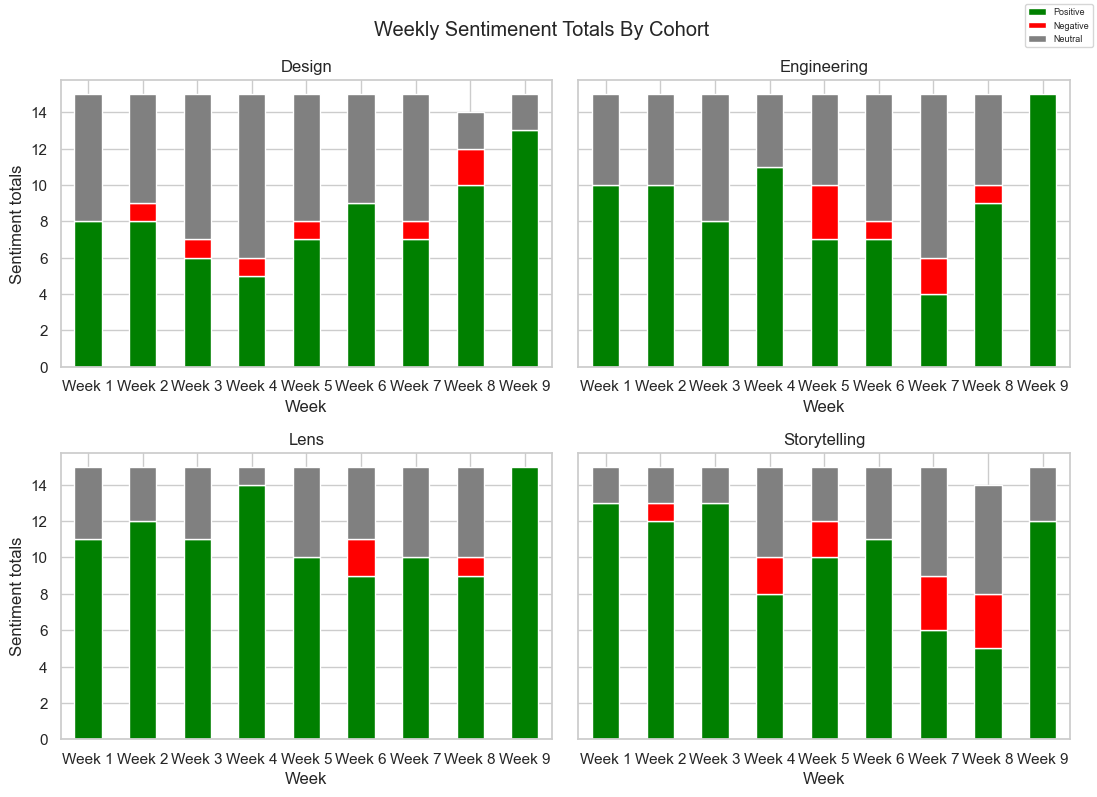

In [358]:
sentiment_week_cohort = data.groupby(['Week', 'Cohort', 'Sentiment']).size().unstack().fillna(0).reset_index()
sentiment_week_cohort.columns.name = None
sentiment_week_cohort.rename(columns={'+': 'Positive', '-': 'Negative', '/': 'Neutral'}, inplace=True)

df = sentiment_week_cohort.copy()

week_order = sorted(df["Week"].unique(), key=lambda s: int(s.split()[1]))
df["Week"] = pd.Categorical(df["Week"], categories=week_order, ordered=True)

cohorts = ["Design", "Engineering", "Lens", "Storytelling"]

colors = ["green", "red", "grey"]  

fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharey=True)
axes = axes.flatten()

for ax, cohort in zip(axes, cohorts):
    sub = df[df["Cohort"] == cohort]
    agg = sub.groupby("Week")[["Positive", "Negative", "Neutral"]].sum()

    agg.plot(kind="bar", stacked=True, ax=ax, color=colors, legend=False)

    ax.set_title(cohort)
    ax.set_xlabel("Week")
    ax.set_ylabel("Sentiment totals")
    ax.tick_params(axis="x", rotation=0)

fig.suptitle('Weekly Sentimenent Totals By Cohort')
fig.legend(["Positive", "Negative", "Neutral"], loc="upper right", fontsize=6.5)

plt.tight_layout()
plt.show()


/var/folders/lm/91n7h9b14bz844p940x4ycd00000gn/T/ipykernel_79324/2400042230.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = sub.groupby("Week")[["Hopeful", "Fearful", "Neutral"]].sum()
/var/folders/lm/91n7h9b14bz844p940x4ycd00000gn/T/ipykernel_79324/2400042230.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = sub.groupby("Week")[["Hopeful", "Fearful", "Neutral"]].sum()
/var/folders/lm/91n7h9b14bz844p940x4ycd00000gn/T/ipykernel_79324/2400042230.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to 

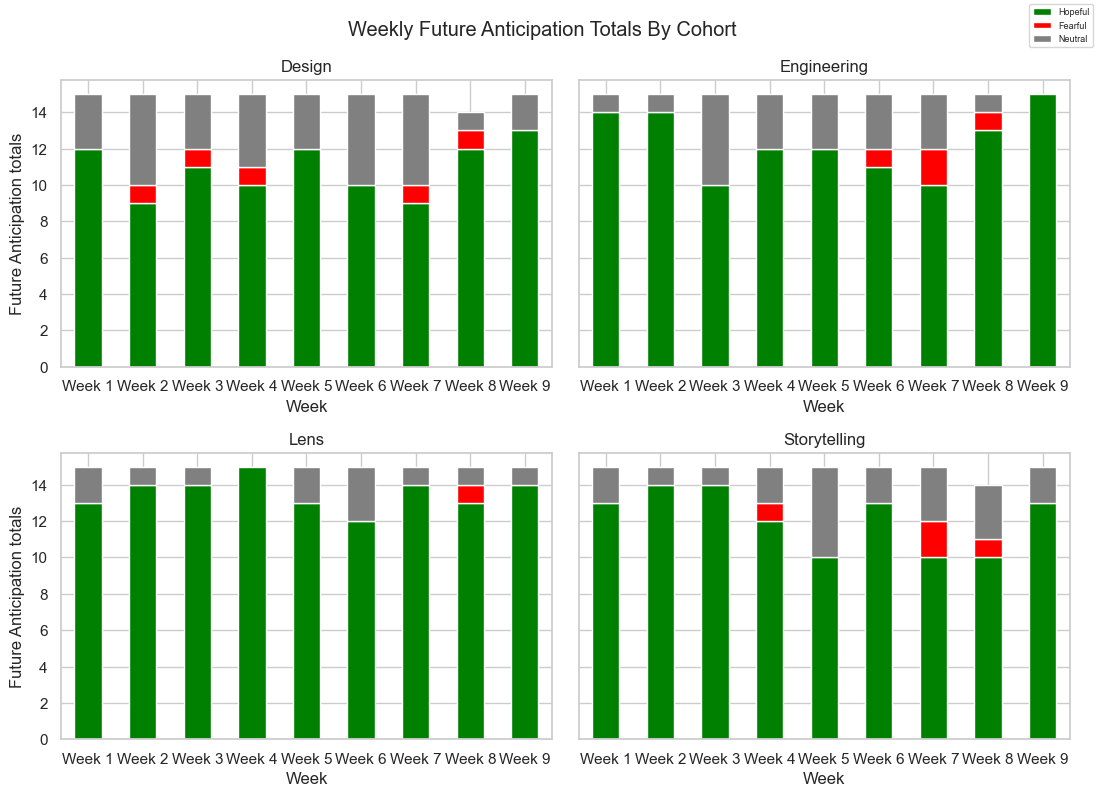

In [360]:
anticipation_week_cohort = data.groupby(['Week', 'Cohort', 'Future Anticipation']).size().unstack().fillna(0).reset_index()
anticipation_week_cohort.columns.name = None
anticipation_week_cohort.rename(columns={'hopeful': 'Hopeful', 'fearful': 'Fearful', 'neutral': 'Neutral'}, inplace=True)

df = anticipation_week_cohort.copy()

week_order = sorted(df["Week"].unique(), key=lambda s: int(s.split()[1]))
df["Week"] = pd.Categorical(df["Week"], categories=week_order, ordered=True)

cohorts = ["Design", "Engineering", "Lens", "Storytelling"]

colors = ["green", "red", "grey"]  

fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharey=True)
axes = axes.flatten()

for ax, cohort in zip(axes, cohorts):
    sub = df[df["Cohort"] == cohort]
    agg = sub.groupby("Week")[["Hopeful", "Fearful", "Neutral"]].sum()

    agg.plot(kind="bar", stacked=True, ax=ax, color=colors, legend=False)

    ax.set_title(cohort)
    ax.set_xlabel("Week")
    ax.set_ylabel("Future Anticipation totals")
    ax.tick_params(axis="x", rotation=0)

fig.suptitle('Weekly Future Anticipation Totals By Cohort')
fig.legend(["Hopeful", "Fearful", "Neutral"], loc="upper right", fontsize=6.5)

plt.tight_layout()
plt.show()


/var/folders/lm/91n7h9b14bz844p940x4ycd00000gn/T/ipykernel_79324/3651686685.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = sub.groupby("Week")[["both balanced", "both heavy", "life-heavy", "no mention", "work-heavy"]].sum()
/var/folders/lm/91n7h9b14bz844p940x4ycd00000gn/T/ipykernel_79324/3651686685.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = sub.groupby("Week")[["both balanced", "both heavy", "life-heavy", "no mention", "work-heavy"]].sum()
/var/folders/lm/91n7h9b14bz844p940x4ycd00000gn/T/ipykernel_79324/3651686685.py:18: FutureWarning: The default of observed=False is deprecated an

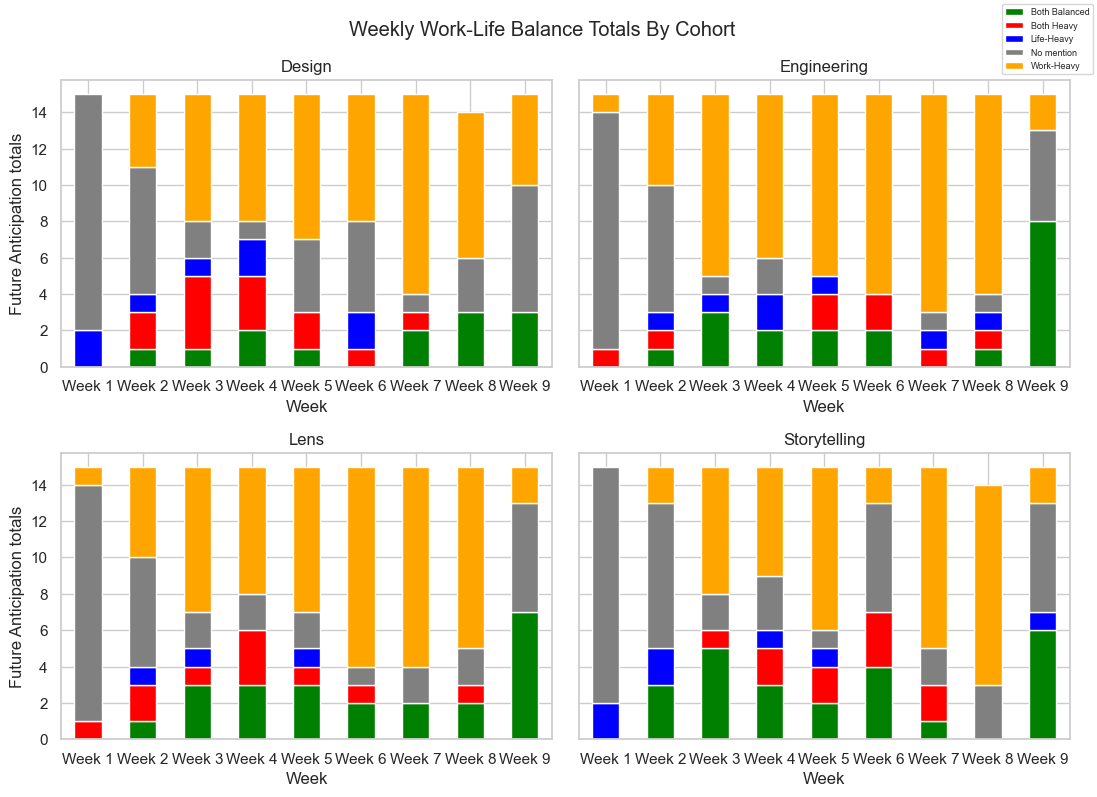

In [431]:
work_life_week_cohort = data.groupby(['Week', 'Cohort', 'Work/Life Balance']).size().unstack().reset_index().fillna(0)
work_life_week_cohort.head()

df = work_life_week_cohort.copy()

week_order = sorted(df["Week"].unique(), key=lambda s: int(s.split()[1]))
df["Week"] = pd.Categorical(df["Week"], categories=week_order, ordered=True)

cohorts = ["Design", "Engineering", "Lens", "Storytelling"]

colors = ["green", "red", "blue", "grey", "orange"]  

fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharey=True)
axes = axes.flatten()

for ax, cohort in zip(axes, cohorts):
    sub = df[df["Cohort"] == cohort]
    agg = sub.groupby("Week")[["both balanced", "both heavy", "life-heavy", "no mention", "work-heavy"]].sum()

    agg.plot(kind="bar", stacked=True, ax=ax, color=colors, legend=False)

    ax.set_title(cohort)
    ax.set_xlabel("Week")
    ax.set_ylabel("Future Anticipation totals")
    ax.tick_params(axis="x", rotation=0)

fig.suptitle('Weekly Work-Life Balance Totals By Cohort')
fig.legend(["Both Balanced", "Both Heavy", "Life-Heavy", "No mention", "Work-Heavy"], loc="upper right", fontsize=6.5)

plt.tight_layout()
plt.show()



### 4) Persona Specific Visualizations

- The 4 personas include:
    - Blossoming Grinder: A participant who demonstrated steady growth across the program, turning consistency into measurable progress.
    - Confidence Catalyst: A participant who began unsure or anxious, then gained confidence through structured learning and momentum.
    - Resilience Builder: A participant who faced recurring academic or personal challenges but continued moving forward without disengaging.
    - Global Mover: A participant who relocated or traveled far to participate, bringing an outside perspective shaped by movement and adaptation.


- I clustered participants based on emotional trajectory and consistency observed across weekly reflection tallies. Correlation strength from the heatmap helped identify drivers like confidence gains, setbacks, and evolving outlook, which were then translated into persona labels for clearer cohort comparisons.

In [ ]:
# Matching the individual to the persona I think they best represented
personas = ['Blossoming Grinder', 'Confidence Catalyst', 'Blossoming Grinder', 'Resilience Builder', 'Confidence Catalyst', 'Blossoming Grinder',
            'Confidence Catalyst', 'Resilience Builder', 'Confidence Catalyst', 'Confidence Catalyst', 'Blossoming Grinder', 'Confidence Catalyst',
            'Resilience Builder', 'Blossoming Grinder', 'Blossoming Grinder', 'Global Mover', 'Confidence Catalyst', 'Blossoming Grinder', 
            'Blossoming Grinder', 'Confidence Catalyst', 'Resilience Builder', 'Blossoming Grinder', 'Resilience Builder', 'Confidence Catalyst',
            'Confidence Catalyst', 'Blossoming Grinder', 'Blossoming Grinder', 'Confidence Catalyst', 'Confidence Catalyst', 'Blossoming Grinder',
            'Resilience Builder', 'Global Mover', 'Confidence Catalyst', 'Confidence Catalyst', 'Confidence Catalyst', 'Resilience Builder',
            'Confidence Catalyst', 'Blossoming Grinder', 'Confidence Catalyst', 'Confidence Catalyst', 'Confidence Catalyst', 'Confidence Catalyst',
            'Confidence Catalyst', 'Confidence Catalyst', 'Confidence Catalyst', 'Blossoming Grinder', 'Resilience Builder', 'Confidence Catalyst',
            'Blossoming Grinder', 'Confidence Catalyst', 'Confidence Catalyst', 'Blossoming Grinder', 'Global Mover', 'Confidence Catalyst',
            'Confidence Catalyst', 'Blossoming Grinder', 'Global Mover', 'Global Mover', 'Blossoming Grinder', 'Resilience Builder']

#### A peek into the new dataframe

In [ ]:
new_df = data.copy()

new_df = new_df.reset_index().rename(columns={'index': 'Participant'})
new_df

participant_list = new_df["Participant"].unique().tolist()
persona_map = dict(zip(participant_list, personas))

new_df["Persona"] = new_df["Participant"].map(persona_map)

new_df.head()


- Pie chart showing the percentages of participants in each persona

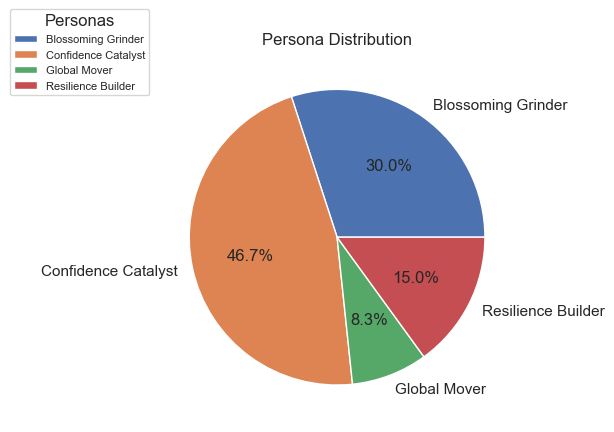

In [422]:
pie_chart = new_df.groupby('Persona')['Participant'].nunique().reset_index()

plt.pie(pie_chart['Participant'], labels=pie_chart['Persona'], autopct='%1.1f%%')
plt.title("Persona Distribution")

# Add a legend using the same labels (fixes missing handles)
plt.legend(labels=pie_chart['Persona'], loc="center left", title="Personas", fontsize=8, bbox_to_anchor=(-0.4, 1))

plt.show()



#### Subplot displaying the persona's per cohort

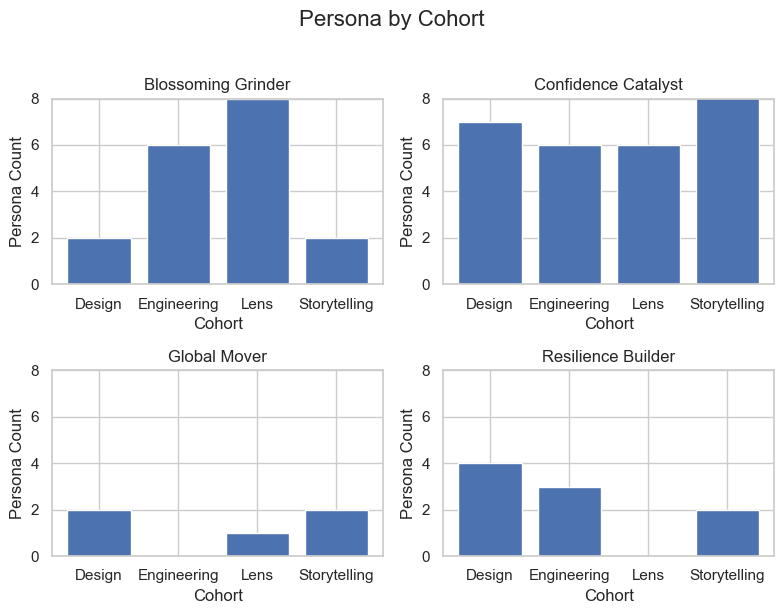

In [436]:
chart = new_df.groupby(['Persona', 'Cohort'])['Participant'].nunique().unstack().fillna(0).reset_index()
chart.columns.name = None

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()


for i, row in enumerate(chart["Persona"].tolist()):
    values = chart[chart["Persona"] == row][["Design", "Engineering", "Lens", "Storytelling"]].values.flatten()
    axes[i].bar(["Design", "Engineering", "Lens", "Storytelling"], values)
    axes[i].set_title(row)
    axes[i].set_xlabel("Cohort")
    axes[i].set_ylabel("Persona Count")

for ax in axes:
    ax.set_ylim(0, 8)


fig.suptitle("Persona by Cohort", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 5) Recommendations

- Teamwork & Cohort-Building Workshop during Week 5 or 6 module, reinforcing collaboration through scenario-based category tagging and conflict-resolution simulations
- Since Sentiment and Future Anticipation was the strongest association (0.51), the program should pair weekly reflection activities with guided future-planning prompts to maintain momentum

## 6) Going Forward

- Add machine-learning persona prediction that classifies participants into personas using category patterns from diary themes
- Expand persona features by including demographic attributes to improve context when predicting persona groups
- Use entrance and exit surveys to collect baseline emotional tone and final growth signals for clearer cohort-level comparisons
- Compare survey responses to weekly sentiment shifts to validate persona accuracy and evolution over time
- Add age range, academic background, and geographic region as optional attributes for more detailed demographic analysis

## Thank you for looking all the way through!!